# Outlier Treatment

# A] Functions

## 1. General

### Get list of Continues Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_continuous_variables(dataframe):
    """
    Get a list of continuous variables from a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - list: List of continuous variable names.
    """
    continuous_variables = dataframe.select_dtypes(include=['float64', 'int64']).columns.tolist()
    return continuous_variables

### Define Dictionary - Descriptive statistics
    Dictionary specifying the statistics to calculate for each variable.
    Key: Each key in the dictionary represents the name of a statistic want to calculate. 
    This could be any descriptive statistic interested in, such as 'Min', 'Max', 'Mean', 'Median', 'Q1', or 'Q3'. 
    
    Value: Each value in the dictionary represents 'NumPy' function used to calculate the corresponding statistic. 
    
    Example: {'Min': np.min, 'Max': np.max, 'Mean': np.mean, 'Median': np.median, 'Q1': lambda x: np.percentile(x, 25), 'Q3': lambda x: np.percentile(x, 75)}

In [3]:
import numpy as np

# Define the statistics you want to calculate
stats_dict = {'Min': np.min, 'Max': np.max, 'Mean': np.mean, 'Median': np.median, 'Q1': lambda x: np.percentile(x, 25), 'Q3': lambda x: np.percentile(x, 75)}

## 2. To analysis Outliers

### Display Histogram and Box-plot

In [4]:
def plot_continuous_variables(dataframe, continuous_variables):
    """
    Display histogram and box plot for a list of continuous variables in a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - continuous_variables (list): List of continuous variable names to plot.
    """
    # Select only continuous variables from the DataFrame
    df_continuous = dataframe[continuous_variables]
    
    ## Display Histogram and Boxplot group by each continuous variable.  
    # Display histograms for each continuous variable
    for column in df_continuous.columns:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df_continuous[column], kde=True)
        plt.title(f'Histogram of {column}')

        # Display box plots for each continuous variable
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_continuous[column])
        plt.title(f'Box Plot of {column}')

        plt.tight_layout()
        plt.show()
        
    # Display Continuous variables group by Histogram and Boxplot 
    # Display histograms
    # dataframe.hist(bins=20, figsize=(10, 6), column=continuous_variables)
    # plt.suptitle('Histograms of Continuous Variables', y=1.02)
    # plt.show()

    ## Display box plots
    # plt.figure(figsize=(10, 6))
    # sns.boxplot(data=dataframe[continuous_variables])
    # plt.title('Box Plots of Continuous Variables')
    # plt.show()

### Get skewness of Continuous Variables

In [5]:
def display_skewness_table(dataframe, continuous_variables):
    # Select only the continuous variables from the DataFrame
    df_continuous = dataframe[continuous_variables]

    # Calculate skewness for each continuous variable
    # skewness_values = df_continuous.apply(lambda x: x.skew()).to_frame('Skewness')
    skewness_values = df_continuous.skew().to_frame('Skewness')
    

    # Display the skewness table
    print("Skewness Table:")
    print(skewness_values)
    
    # Alternative 2:
    # Calculate skewness for each continuous variable
    # skewness_values = df_continuous.skew()
    # Create a DataFrame to display the skewness values
    # skewness_table = pd.DataFrame({
    #    'Variable': skewness_values.index,
    #    'Skewness': skewness_values.values
    # })

###  Get Discriptive Stats of Continuous Variable

In [6]:
def continuous_variable_stats(df, continuous_variables, stats_dict):
    """
    Generate customized Discriptive statistics table for continuous variables in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - continuous_variables: List of names of continuous variables.
    - stats_dict: Dictionary specifying the statistics to calculate for each variable.
                  Example: {'Min': np.min, 'Max': np.max, 'Mean': np.mean, 'Median': np.median, 'Q1': lambda x: np.percentile(x, 25), 'Q3': lambda x: np.percentile(x, 75)}

    Returns:
    - stats_table: DataFrame containing customized statistics for each continuous variable.
    """
    stats_table = pd.DataFrame(index=continuous_variables, columns=stats_dict.keys())

    for var in continuous_variables:
        data = df[var]
        for stat_name, stat_func in stats_dict.items():
            stats_table.loc[var, stat_name] = stat_func(data)

    return stats_table

## 3. To Treat Outlieres

### Remove implausible values
**Dataset:** Your original dataset.
**Outlier Removal parameter:** The data structure(directory) specifying the method and value ranges for each parameter.
Function takes the dataset and the Outlier Removal parameter data structure as input and removes outlieres values according to the specified method and ranges. If an upper or lower bound value is NA, it will not remove values from that bound.

For the "implausible" method, it removes values from the dataset that fall outside of the specified range  
    for each parameter.
    For the "IQR" method, it calculates the lower and upper bounds based on the interquartile range (IQR). 
    An IQR range value of 1 indicates that the bound is applicable. Lower bound is set to (Q1 - 1.5 * IQR), 
    and upper bound is set to (Q3 + 1.5 * IQR).

In [7]:
def remove_outliers_values(dataset, outlier_removal_params):
    """
    Function to remove implausible values from the dataset based on the provided outlier removal parameters.
    
    Parameters:
        - dataset (pd.DataFrame): The dataset containing the data.
        - outlier_removal_params (dict): Dictionary specifying the outlier removal method and bounds for each parameter.
        
    Returns:
        - Updated dataset after removing implausible values.
    """
    for param, removal_info in outlier_removal_params.items():
        method = removal_info['method']
        bounds = removal_info['bounds']

        if method == 'implausible':
            lower_bound, upper_bound = bounds
            if lower_bound is not None:
                dataset = dataset[dataset[param] >= lower_bound]
            if upper_bound is not None:
                dataset = dataset[dataset[param] <= upper_bound]
        elif method == 'IQR':
            q1 = dataset[param].quantile(0.25)  # 1st quartile
            q3 = dataset[param].quantile(0.75)  # 3rd quartile
            iqr = q3 - q1  # Interquartile range
            # Calculate lower bound (Q1 - 1.5 * IQR) if bounds[0] is 1, else set to None
            lower_bound = q1 - 1.5 * iqr if bounds[0] == 1 else None
            # Calculate upper bound (Q3 + 1.5 * IQR) if bounds[1] is 1, else set to None
            upper_bound = q3 + 1.5 * iqr if bounds[1] == 1 else None
            if lower_bound is not None:
                dataset = dataset[dataset[param] >= lower_bound]
            if upper_bound is not None:
                dataset = dataset[dataset[param] <= upper_bound]

    return dataset

### Select Transformation Method
Function to select the appropriate transformation method for each continuous variable in a dataset.
- When variables has 0 or -ve values, square root transfromation is selected.
- To determine which transformation method (log or square root) is better for variables with positive values, the skewness of the original variable with the skewness of the transformed variable is compared. Skewness measures the asymmetry of the distribution of values. 
Alternative to skewness is Statistical Tests Shapiro-Wilk test.

In [8]:
#import numpy as np
#import pandas as pd

def select_transformation(continuous_variables, dataset):
    """
    Selects the appropriate transformation method for each continuous variable in the dataset.

    Parameters:
    continuous_variables (list): List of continuous variable names.
    dataset (pandas.DataFrame): Dataset containing the variables.

    Returns:
    dict: Dictionary with variable names as keys and transformation methods as values.
    """

    transformation_dict = {}

    for var in continuous_variables:
        values = dataset[var]

        # Check for positive values
        if (values <= 0).any():
            transformation_dict[var] = 'Square root'
        else:
            # Calculate skewness of original variable
            original_skewness = values.skew()

            # Transform variable using log and square root
            transformed_log = np.log(values)
            transformed_sqrt = np.sqrt(values)

            # Calculate skewness of transformed variables
            log_skewness = transformed_log.skew()
            sqrt_skewness = transformed_sqrt.skew()
            
            # Print Skewness values
            print("Variable:", var)
            print("Original Skewness:", original_skewness)
            print("Log Skewness:", log_skewness)
            print("Sqrt Skewness:", sqrt_skewness)

            # Select transformation method with lower skewness
            if abs(log_skewness) < abs(sqrt_skewness):
                transformation_dict[var] = 'Log'
            else:
                transformation_dict[var] = 'Square root'

    return transformation_dict

### Transform Variables
 Perform the appropriate transformations on the variables and return a new dataset with transformed variables.

In [9]:
import pandas as pd
import numpy as np

def transform_variables(dataset, transformation_dict):
    """
    Transforms variables in the dataset according to the specified transformation methods.

    Parameters:
    dataset (pandas.DataFrame): Original dataset.
    transformation_dict (dict): Dictionary mapping variable names to transformation methods.

    Returns:
    pandas.DataFrame: New dataset with transformed variables.
    """
    transformed_dataset = dataset.copy()

    for var, method in transformation_dict.items():
        if method == 'Log':
            transformed_dataset[var] = np.log(transformed_dataset[var])
        elif method == 'Square root':
            transformed_dataset[var] = np.sqrt(transformed_dataset[var])

    return transformed_dataset

# B] Data 
## Cardio
###  Data Pre-processing
1. Read Data and display header
2. Remove Missing Data
3. Get list of Continues Variables

In [10]:
# Load the CardioData.csv data file from the data folder
cardio_file_path = '../input/dataset/tidyCardioData.csv'  # Outlier Treatment - Remove Implausiable value
diabetes2_file_path = '../input/dataset/PimaIndiansDiabetes2.xlsx'
cardioData = pd.read_csv(cardio_file_path)

# Display the head of the dataframe
print(cardioData)

       Unnamed: 0     id  age  gender  height  weight  ap_hi  ap_lo  \
0               1      0   50    Male     168    62.0    110     80   
1               2      1   55  Female     156    85.0    140     90   
2               3      2   52  Female     165    64.0    130     70   
3               4      3   48    Male     169    82.0    150    100   
4               5      4   48  Female     156    56.0    100     60   
...           ...    ...  ...     ...     ...     ...    ...    ...   
69971       69972  99993   53    Male     168    76.0    120     80   
69972       69973  99995   62  Female     158   126.0    140     90   
69973       69974  99996   52    Male     183   105.0    180     90   
69974       69975  99998   61  Female     163    72.0    135     80   
69975       69976  99999   56  Female     170    72.0    120     80   

             cholesterol          gluc smoke alco active   cardio  
0                 Normal        Normal    No   No    Yes   Absent  
1      Well

In [11]:
# Remove rows with missing values
cardioCleanedData = cardioData.dropna()

# Display the cleaned DataFrame
print(cardioCleanedData)

       Unnamed: 0     id  age  gender  height  weight  ap_hi  ap_lo  \
0               1      0   50    Male     168    62.0    110     80   
1               2      1   55  Female     156    85.0    140     90   
2               3      2   52  Female     165    64.0    130     70   
3               4      3   48    Male     169    82.0    150    100   
4               5      4   48  Female     156    56.0    100     60   
...           ...    ...  ...     ...     ...     ...    ...    ...   
69971       69972  99993   53    Male     168    76.0    120     80   
69972       69973  99995   62  Female     158   126.0    140     90   
69973       69974  99996   52    Male     183   105.0    180     90   
69974       69975  99998   61  Female     163    72.0    135     80   
69975       69976  99999   56  Female     170    72.0    120     80   

             cholesterol          gluc smoke alco active   cardio  
0                 Normal        Normal    No   No    Yes   Absent  
1      Well

In [12]:
# Get list of Continues Variables
cardio_continuous_vars_list = get_continuous_variables(cardioCleanedData)
print("Continuous Variables:", cardio_continuous_vars_list)

Continuous Variables: ['Unnamed: 0', 'id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']


## Thyroid
###  Data Pre-processing
1. Read Data and display header
2. Remove Variables with more that 90% missing values.
3. Remove Missing Data
4. Get list of Continues Variables

In [13]:
# Load the tidyThyroidthyroid.csv data file from the data folder
thyroid_file_path2 = '../input/dataset/tidyThyroidData.csv' # Outlier Treatment- Transform Data
thyroidData = pd.read_csv(thyroid_file_path2)

# Display the head of the dataframe
print(thyroidData)

# Remove rows with missing values
thyroidCleanedData = thyroidData.dropna()

# Display the cleaned DataFrame
print(thyroidCleanedData)

# Get list of Continues Variables
thyorid_continuous_vars_list = get_continuous_variables(thyroidCleanedData)
print("Continuous Variables:", thyorid_continuous_vars_list)

      Unnamed: 0 thyroid  age     sex referral_source  on_thyroxine  \
0              1      No   36  Female           other         False   
1              2      No   40  Female           other         False   
2              3      No   40  Female           other         False   
3              4      No   77  Female           other         False   
4              5      No   51  Female             SVI         False   
...          ...     ...  ...     ...             ...           ...   
5784        5785      No   65    Male           other         False   
5785        5786      No   65  Female           other          True   
5786        5787     Yes   74  Female             SVI         False   
5787        5788      No   42  Female           other          True   
5788        5789      No   42  Female           other         False   

      query_on_thyroxine  on_antithyroid_meds   sick  pregnant  ...  lithium  \
0                  False                False  False     False  ...

# C] Data : Cardio (Remove Implausible Values)

## Anaylsis for Outliers

### Plot Histogram and Box-plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


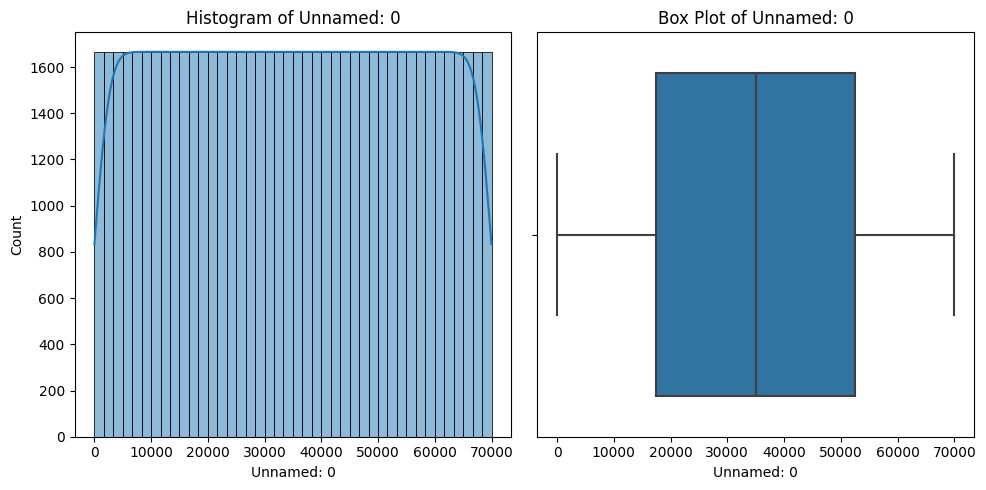

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


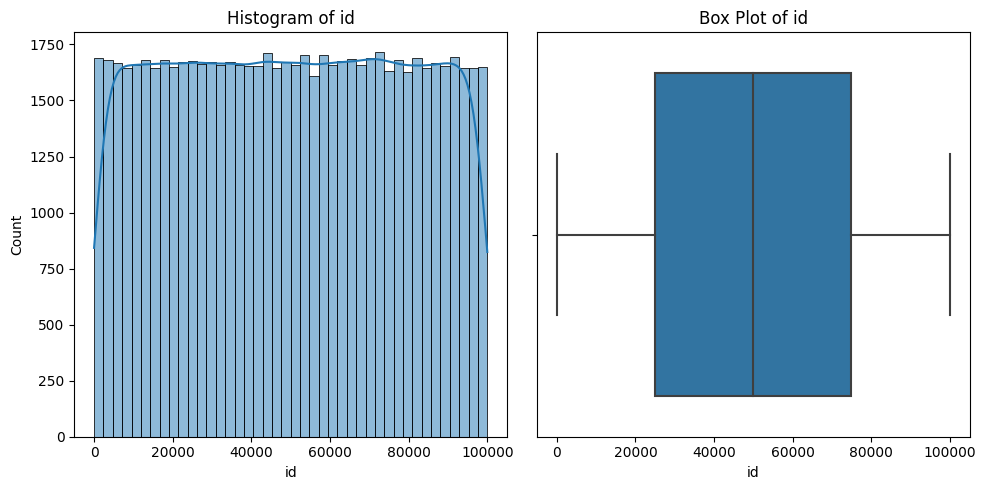

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


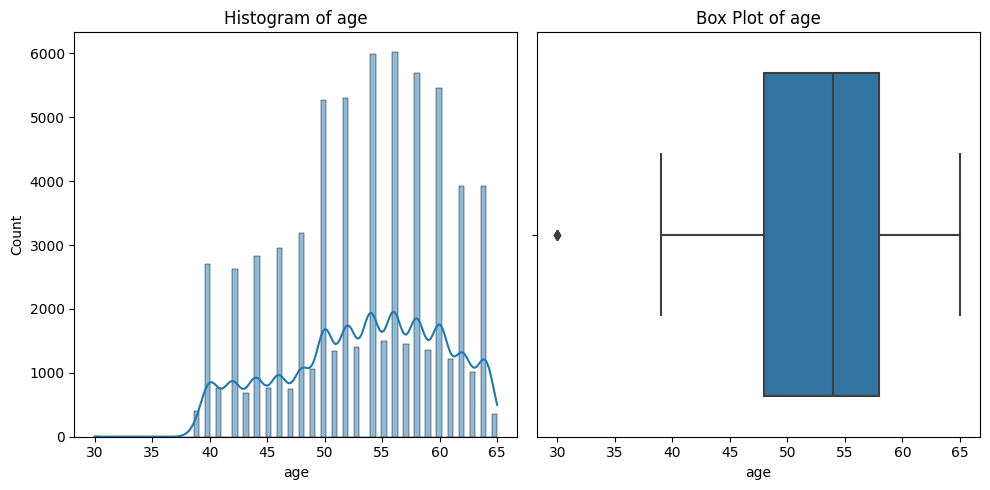

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


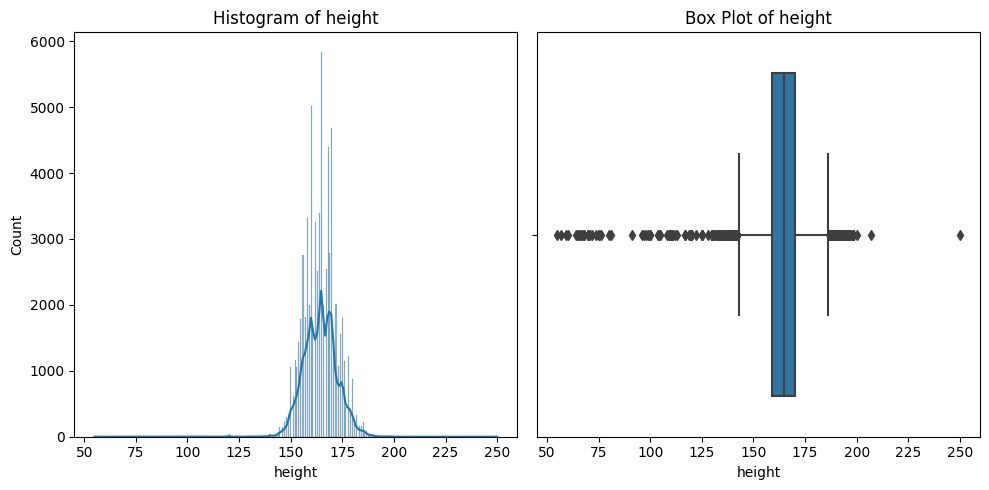

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


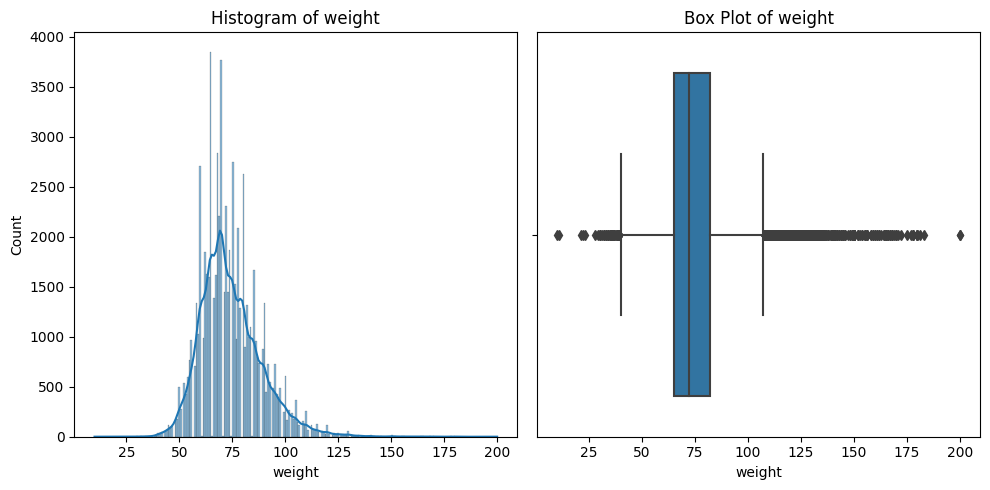

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


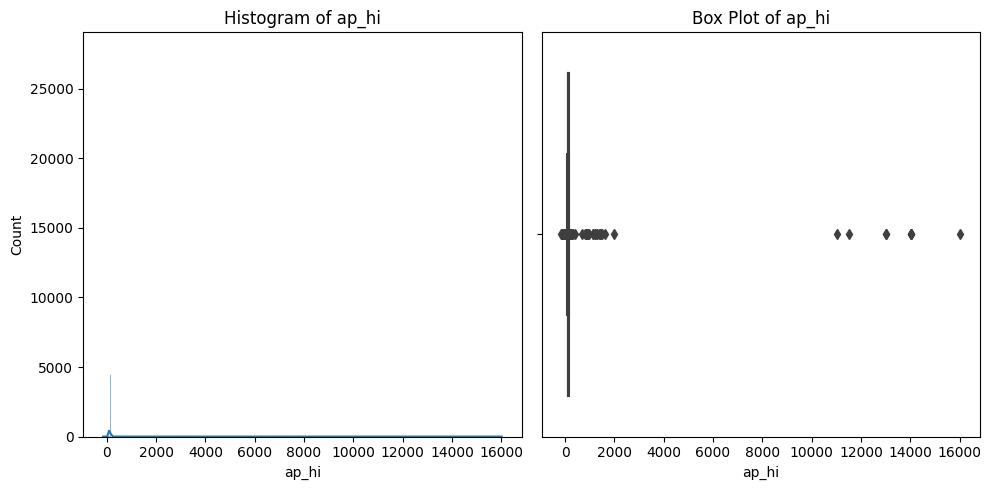

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


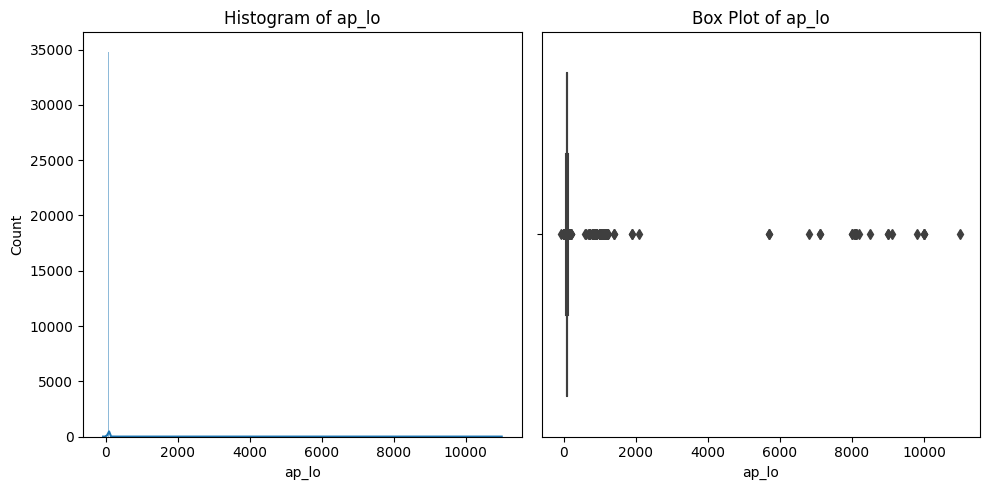

In [14]:
# Display Box Plot and Histogram of continous vars
plot_continuous_variables(cardioCleanedData, cardio_continuous_vars_list)

### Check skewness of Contnuous variable.

In [15]:
#Skewness of Contionus Variables
display_skewness_table(cardioCleanedData, cardio_continuous_vars_list)

Skewness Table:
             Skewness
Unnamed: 0   0.000000
id          -0.000880
age         -0.306470
height      -0.642142
weight       1.011633
ap_hi       85.281695
ap_lo       32.108622


### Discriptive statistics Table

In [16]:
# Get Discriptive statistics table for continuous variables
cardioclean_stats_table = continuous_variable_stats(cardioCleanedData, cardio_continuous_vars_list, stats_dict)

# Display the Discriptive statistics table
print("Customized Discriptive Statistics Table for Continuous Variables:")
print(cardioclean_stats_table)

Customized Discriptive Statistics Table for Continuous Variables:
             Min    Max          Mean   Median        Q1        Q3
Unnamed: 0     1  69976       34988.5  34988.5  17494.75  52482.25
id             0  99999  49964.469147  49984.0  24997.75  74877.25
age           30     65     53.338945     54.0      48.0      58.0
height        55    250    164.359152    165.0     159.0     170.0
weight      10.0  200.0     74.208519     72.0      65.0      82.0
ap_hi       -150  16020    128.820453    120.0     120.0     140.0
ap_lo        -70  11000     96.636261     80.0      80.0      90.0


## Remove implausible Values
### Define implausible value ranges per parameter

    The dictionary outlier_removal_params contains outlier removal parameters for each parameter in the dataset. It specify the methods and value ranges for removing outliers. Here's a summary:

    Each key in the dictionary represents a parameter identifier.
    Each value is a dictionary with two keys:
    
    'method': Specifies the outlier removal method for the parameter ('implausible' or 'IQR').  
    'bounds': Specifies the lower and upper bounds for the outlier removal method. 
    It's a tuple where the first element represents the lower bound, and the second element represents the
    upper bound. 
    If a bound is not applicable, it is represented as NA. 
    If the method is 'IQR', the bounds indicate whether the lower and upper bounds are applicable (1) or not (NA).

In [17]:
import numpy as np

# Dictionary containing outlier removal parameters for each parameter
outlier_removal_params = {
    # For each parameter, specify the outlier removal method and its bounds
    'height': {'method': 'implausible', 'bounds': (100, None)},  
    'weight': {'method': 'implausible', 'bounds': (25, None)},
    'ap_hi': {'method': 'implausible', 'bounds': (20, 280)},
    'ap_lo': {'method': 'implausible', 'bounds': (20, 220)},
    'age': {'method': 'IQR', 'bounds': (1, None)},  # IQR method with lower and upper bounds applicable
    # Add more parameters and their outlier removal parameters as needed
}
print(outlier_removal_params)

{'height': {'method': 'implausible', 'bounds': (100, None)}, 'weight': {'method': 'implausible', 'bounds': (25, None)}, 'ap_hi': {'method': 'implausible', 'bounds': (20, 280)}, 'ap_lo': {'method': 'implausible', 'bounds': (20, 220)}, 'age': {'method': 'IQR', 'bounds': (1, None)}}


### Remove implausible Values

In [18]:
# Implausible Values are removed as per Dictiornay input.
cardioOutlierRemoveData = remove_outliers_values(cardioCleanedData, outlier_removal_params)

## Validate

Customized Discriptive Statistics Table for Continuous Variables:
             Min    Max          Mean   Median        Q1        Q3
Unnamed: 0     1  69976  34987.835617  35000.5  17490.25  52465.75
id             0  99999  49963.519566  50004.5  24993.25  74848.75
age           39     65     53.328242     54.0      48.0      58.0
height       100    250     164.39689    165.0     159.0     170.0
weight      28.0  200.0     74.126602     72.0      65.0      82.0
ap_hi         20    240    126.611431    120.0     120.0     140.0
ap_lo         20    190     81.367039     80.0      80.0      90.0
Skewness Table:
            Skewness
Unnamed: 0 -0.000102
id         -0.000982
age        -0.303623
height     -0.068700
weight      0.999433
ap_hi       0.886517
ap_lo       0.589112


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


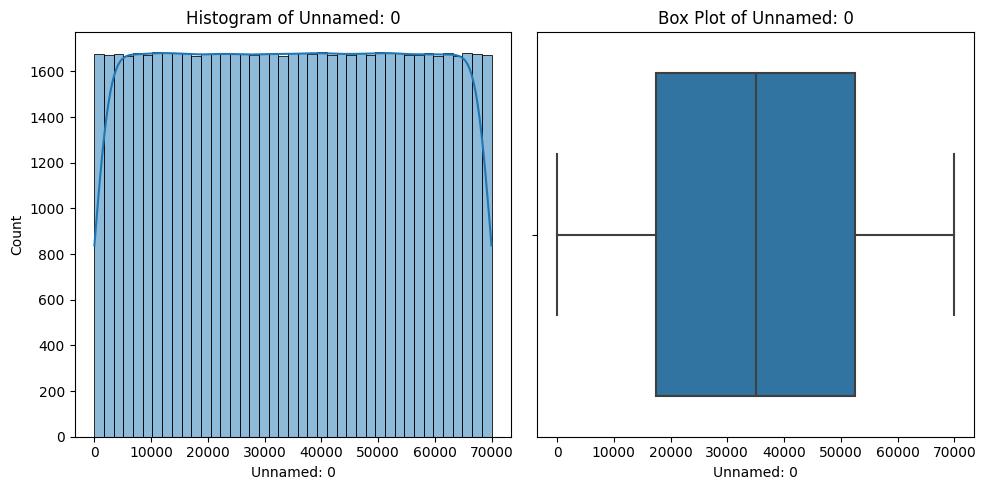

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


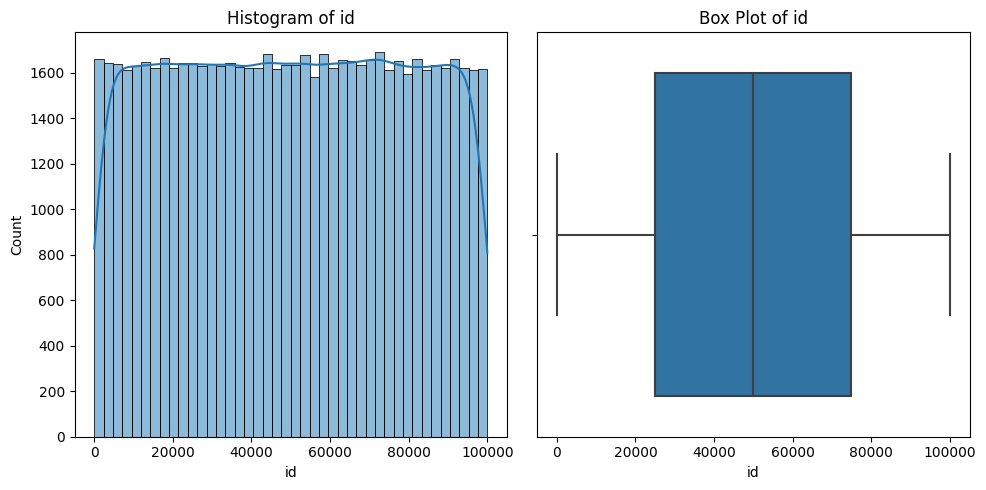

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


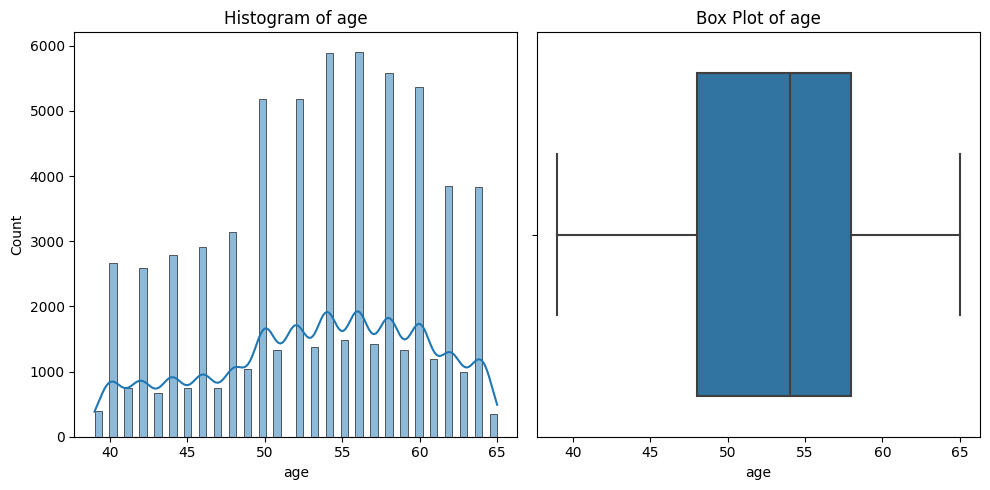

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


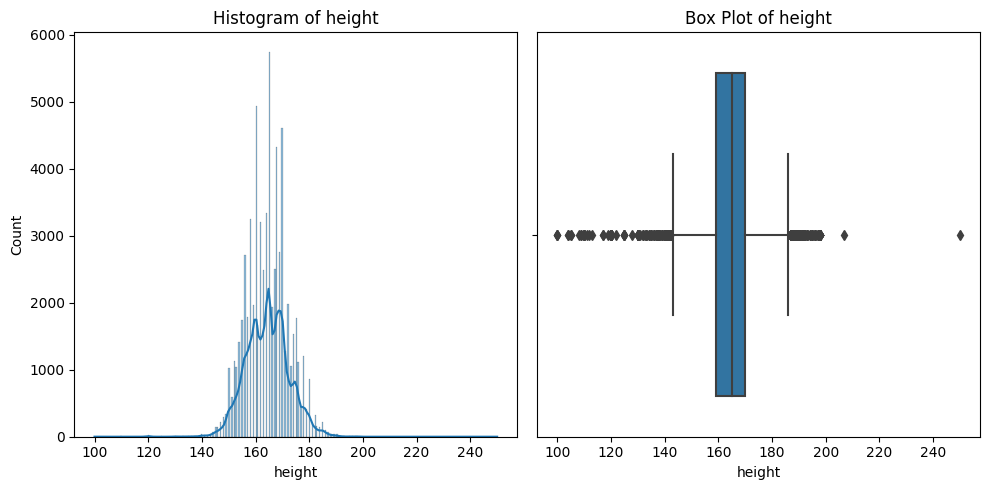

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


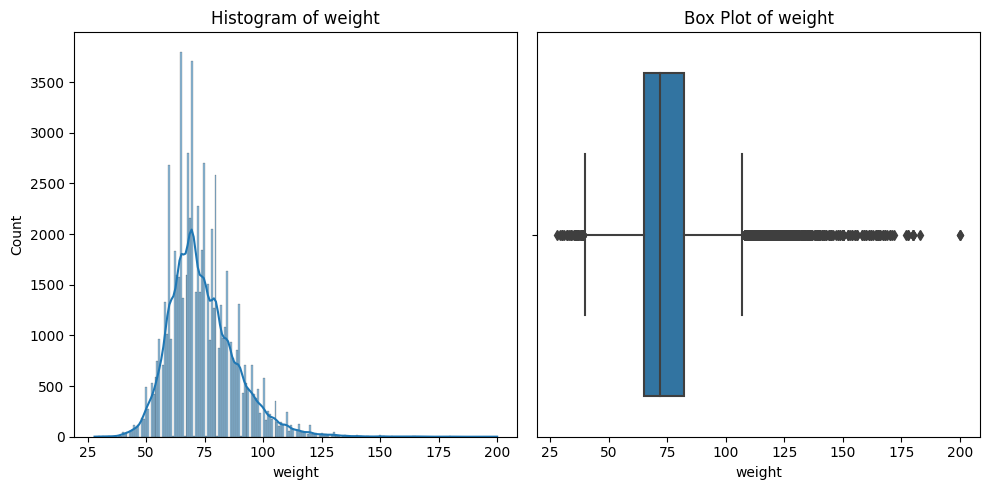

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


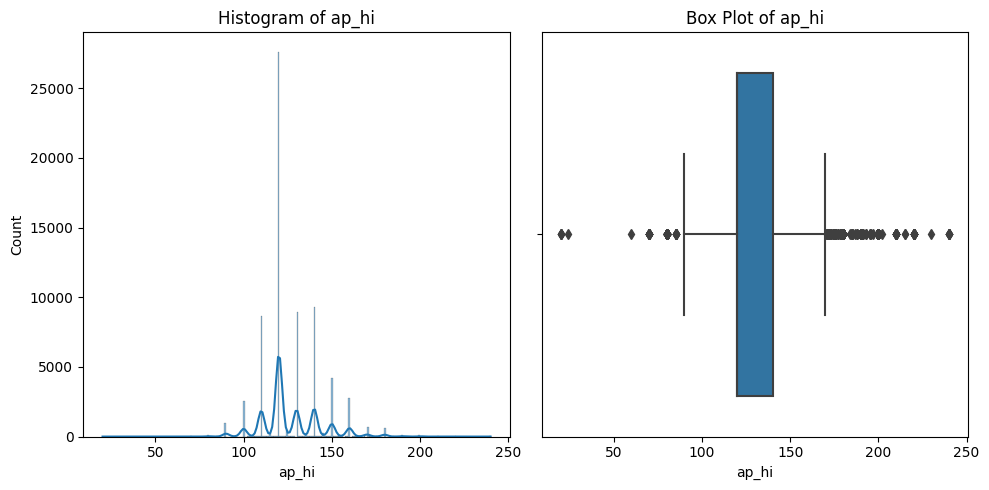

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


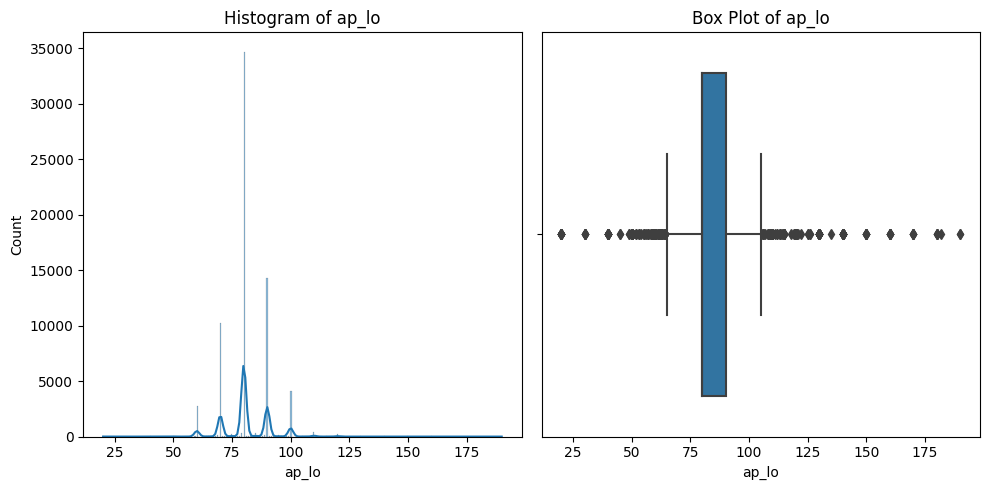

In [19]:
# Get Discriptive statistics table for continuous variables
cardioOutlierRemove_stats_table = continuous_variable_stats(cardioOutlierRemoveData, cardio_continuous_vars_list, stats_dict)

# Display the Discriptive statistics table
print("Customized Discriptive Statistics Table for Continuous Variables:")
print(cardioOutlierRemove_stats_table)

# BoxPlot, Histogram and skewness after removing outlieres
display_skewness_table(cardioOutlierRemoveData, cardio_continuous_vars_list)
plot_continuous_variables(cardioOutlierRemoveData, cardio_continuous_vars_list)

# D] Data : Thyroid (Transform Data)

## Anaylsis for Outliers
### Plot Histogram and Box-plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


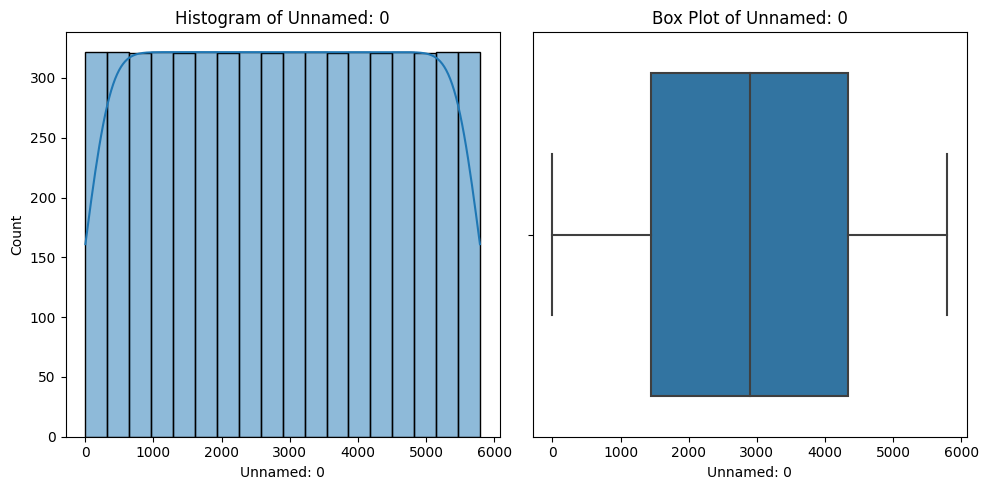

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


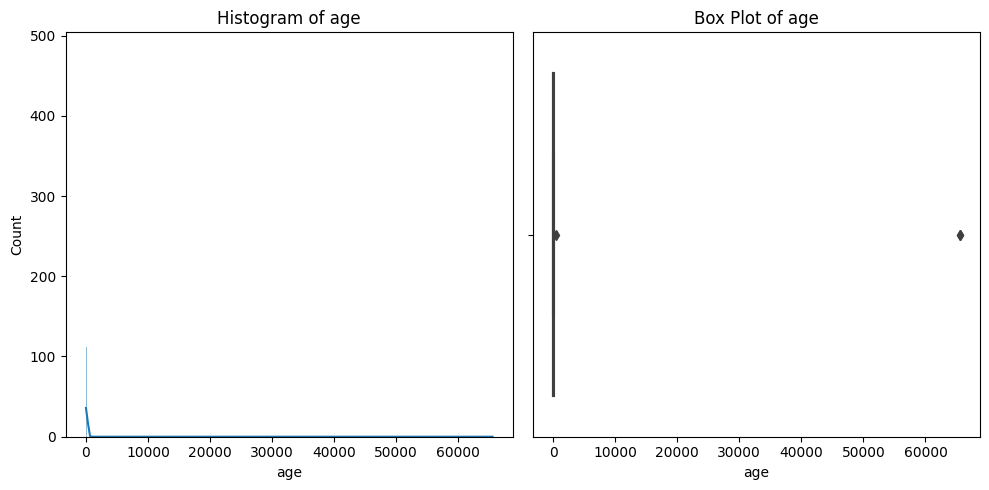

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


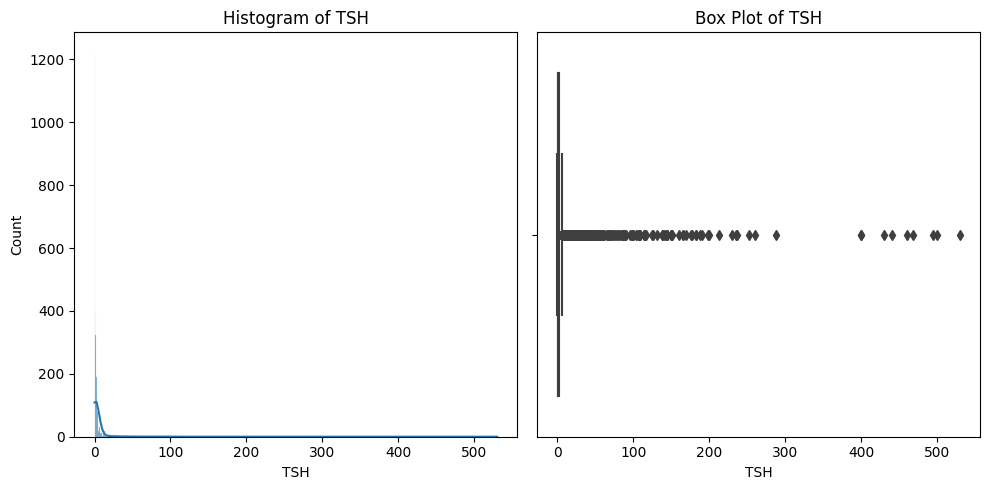

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


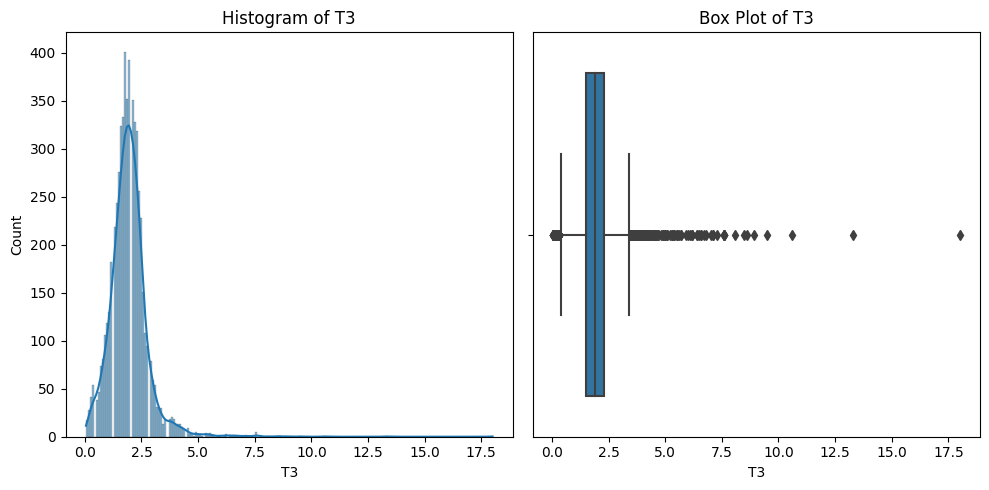

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


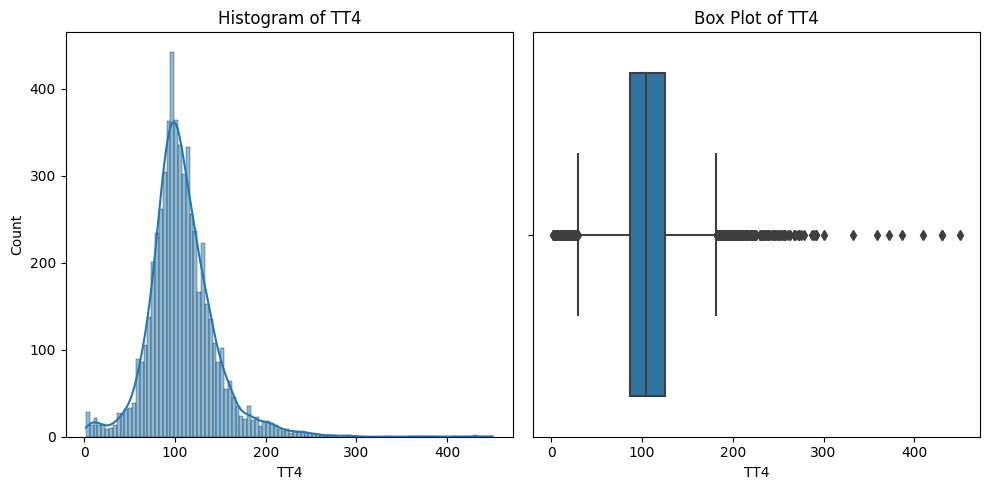

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


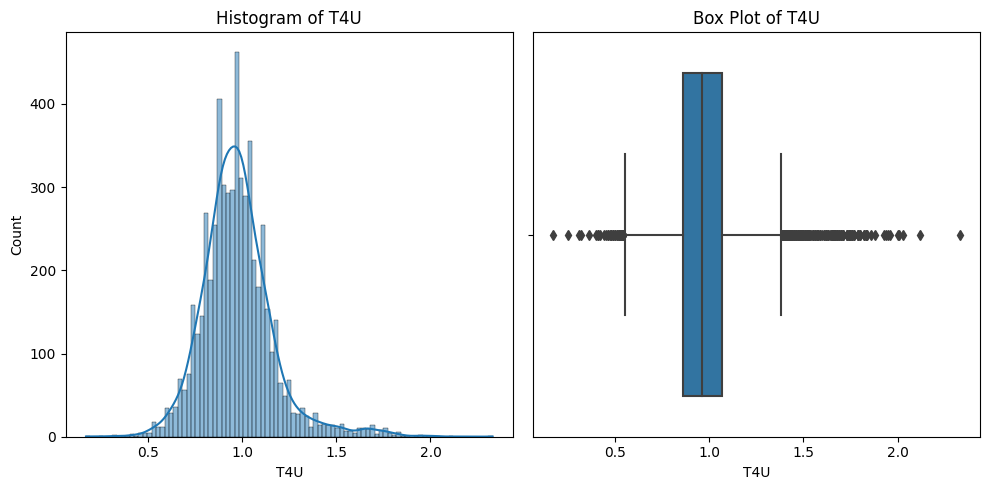

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


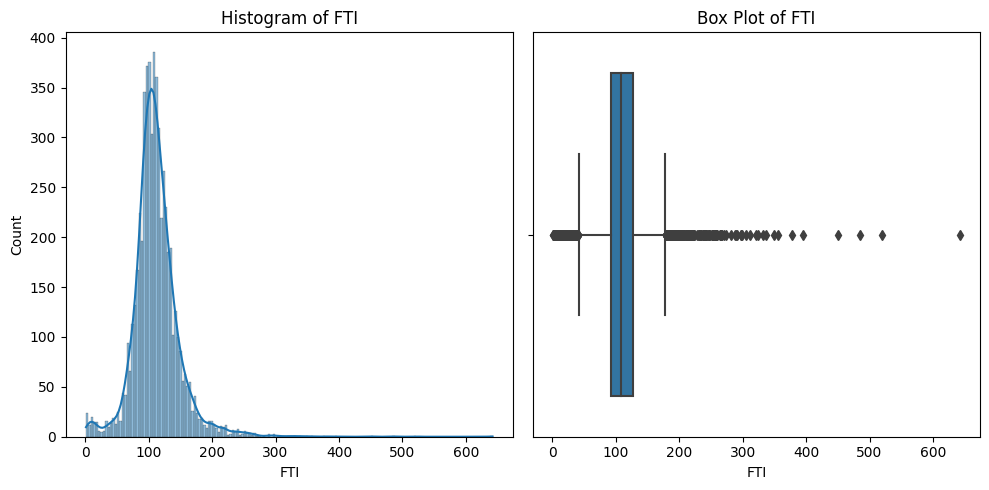

In [20]:
plot_continuous_variables(thyroidCleanedData, thyorid_continuous_vars_list)

### Check Skewness

In [21]:
#Skewness of Contionus Variables
display_skewness_table(thyroidCleanedData, thyorid_continuous_vars_list)

Skewness Table:
             Skewness
Unnamed: 0   0.000000
age         53.765843
TSH         12.820260
T3           3.063066
TT4          1.273549
T4U          1.112914
FTI          1.918643


### Discriptive statistics Table

In [22]:
# Get Discriptive statistics table for continuous variables
thyroidclean_stats_table = continuous_variable_stats(thyroidCleanedData, thyorid_continuous_vars_list, stats_dict)

# Display the Discriptive statistics table
print("Customized Discriptive Statistics Table for Continuous Variables:")
print(thyroidclean_stats_table)

Customized Discriptive Statistics Table for Continuous Variables:
              Min    Max        Mean  Median      Q1      Q3
Unnamed: 0      1   5789      2895.0  2895.0  1448.0  4342.0
age             1  65512   76.291242    56.0    38.0    69.0
TSH         0.005  530.0    5.162651     1.3     0.4     2.6
T3           0.05   18.0    1.948817     1.9     1.5     2.3
TT4           2.0  450.0  107.878089   104.0    87.0   125.0
T4U          0.17   2.33    0.976116    0.96    0.86    1.07
FTI           1.4  642.0  112.130669   109.0    93.0   127.0


## Tranform Data
Transform following contiouns variables;
TSH, T3, TT4, T4U and FTI

### Select Transformation Method

In [23]:
# Select Trnasformation Method
thyroid_continous_var_transform = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
thyroid_transformation_methods = select_transformation(thyroid_continous_var_transform, thyroidCleanedData)
print(thyroid_transformation_methods)

Variable: TSH
Original Skewness: 12.820260498631207
Log Skewness: -0.22924131276881465
Sqrt Skewness: 5.405531367819147
Variable: T3
Original Skewness: 3.063065663342993
Log Skewness: -1.7558858190382303
Sqrt Skewness: 0.30341733999688225
Variable: TT4
Original Skewness: 1.2735491056330046
Log Skewness: -2.9726774822563184
Sqrt Skewness: -0.3512474713654817
Variable: T4U
Original Skewness: 1.1129140858814845
Log Skewness: -0.17406601944064515
Sqrt Skewness: 0.5041599526377979
Variable: FTI
Original Skewness: 1.9186426350029429
Log Skewness: -3.5336264768766057
Sqrt Skewness: -0.3895963101612856
{'TSH': 'Log', 'T3': 'Square root', 'TT4': 'Square root', 'T4U': 'Log', 'FTI': 'Square root'}


### Transform Variables
 Perform the appropriate transformations on the variables and return a new dataset with transformed variables.

In [24]:
# Trnasform Variables as per selected Method
thyroidTransformeData = transform_variables(thyroidCleanedData, thyroid_transformation_methods)

# Validate

## Get Discriptive statistics table for continuous variables
## Display the Discriptive statistics table

In [25]:
thyroidTransfrom_stats_table = continuous_variable_stats(thyroidTransformeData, thyroid_continous_var_transform, stats_dict)
print("Customized Discriptive Statistics Table for Continuous Variables:") 
print(thyroidTransfrom_stats_table)

Customized Discriptive Statistics Table for Continuous Variables:
          Min        Max       Mean     Median        Q1         Q3
TSH -5.298317   6.272877   0.002737   0.262364 -0.916291   0.955511
T3   0.223607   4.242641   1.363681   1.378405  1.224745   1.516575
TT4  1.414214  21.213203  10.221496  10.198039  9.327379   11.18034
T4U -1.771957   0.845868  -0.043038  -0.040822 -0.150823   0.067659
FTI  1.183216  25.337719  10.435398  10.440307  9.643651  11.269428


## Display Skewness Table

In [26]:
display_skewness_table(thyroidTransformeData, thyroid_continous_var_transform) 

Skewness Table:
     Skewness
TSH -0.229241
T3   0.303417
TT4 -0.351247
T4U -0.174066
FTI -0.389596


## Display Historgam and BoxPlot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


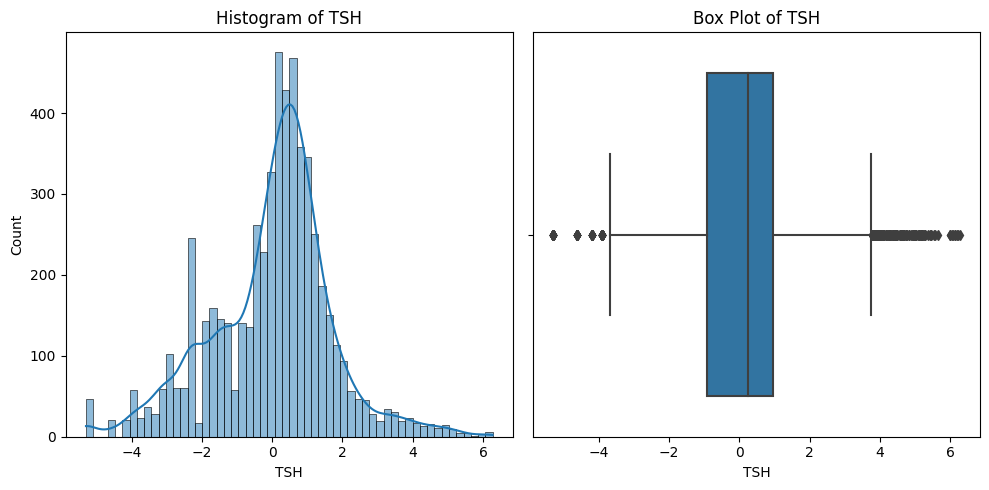

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


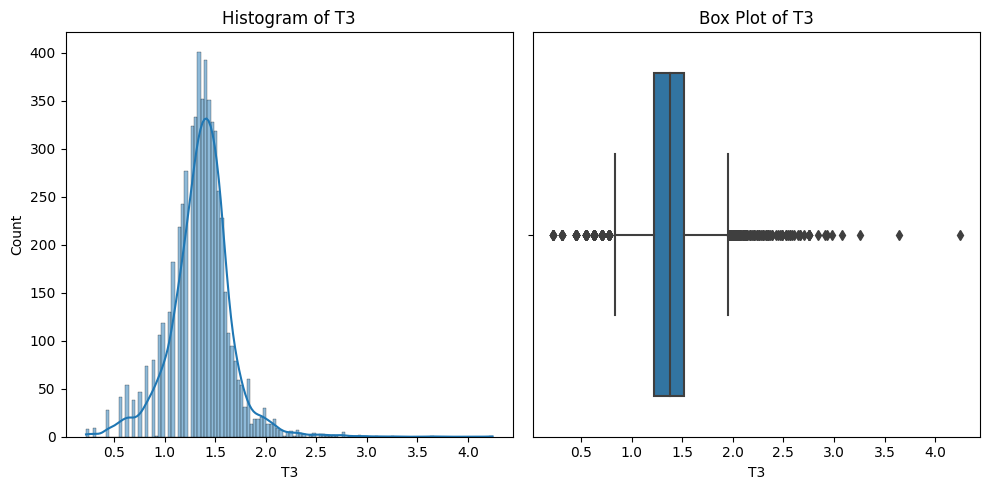

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


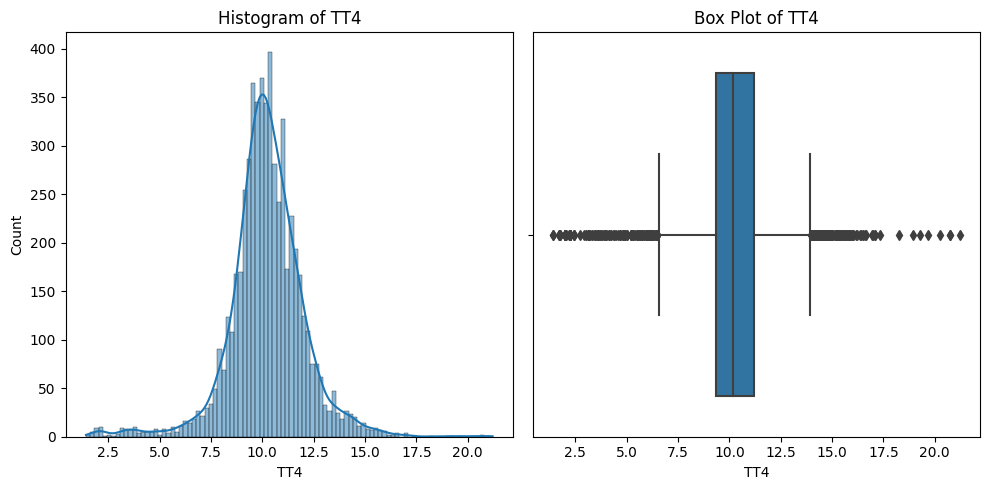

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


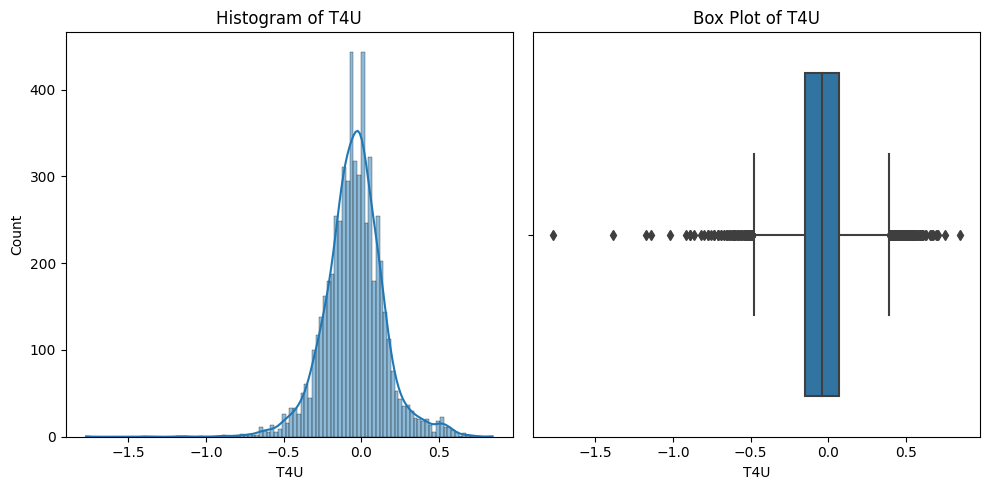

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


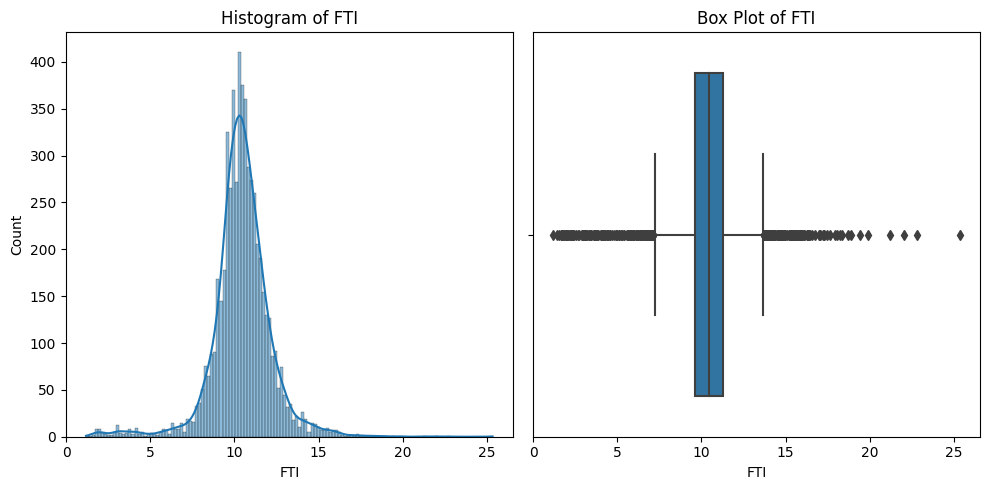

In [27]:
plot_continuous_variables(thyroidTransformeData, thyroid_continous_var_transform)